#  Libraries

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans as rmkm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

import plotly.offline as pyoff
import plotly.graph_objs as go
import matplotlib.cm as cm

import datetime as dt
import feature_engine

from feature_engine.outliers import Winsorizer
import warnings
warnings.filterwarnings("ignore")

In [107]:
# Load Dataset
df = pd.read_csv('dataset.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [108]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12-09-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12-09-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12-09-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12-09-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12-09-2011 12:50,4.95,12680.0,France


In [109]:
df.shape 

(541909, 8)

In [110]:
type (df)

pandas.core.frame.DataFrame

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data Preperations 

In [112]:
def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
object     5
float64    2
int64      1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
CustomerID,float64,406829,4373,135080,12346.0
Description,object,540455,4220,1454,NaN
Country,object,541909,38,0,Australia
InvoiceDate,object,541909,23260,0,01-04-2011 10:00
InvoiceNo,object,541909,25900,0,536365
Quantity,int64,541909,722,0,-80995
StockCode,object,541909,4070,0,10002
UnitPrice,float64,541909,1630,0,-11062.06


In [113]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [114]:
df.loc[(df.UnitPrice<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,08-12-2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,08-12-2011 14:52,-11062.06,NaN,United Kingdom


In [115]:
df.loc[(df.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12-01-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12-01-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12-01-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12-01-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12-01-2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12-09-2011 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12-09-2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12-09-2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12-09-2011 11:58,1.25,17315.0,United Kingdom


In [116]:
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

There are almost 25% missing CustomerID. We need to remove them as there is no way we can get the number of CustomerID

In [117]:
df.Country.value_counts(normalize=True) 

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

We can see that there is maximum proportion (More than 90% of customers) of 'United Kingdom' customers. So we will take 'United Kingdom' customer for our analysis.

In [118]:
df = df[df.Country == 'United Kingdom']

Removing the negative values from UnitPrice and Quantity

In [119]:
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]

#Removing the Null values from the data.
df = df[pd.notnull(df['CustomerID'])]

In [120]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [121]:
#df['Date']=pd.to_datetime(df['Date'])
df.isnull().mean()

InvoiceNo           0.0
StockCode           0.0
Description         0.0
Quantity            0.0
InvoiceDate         0.0
UnitPrice           0.0
CustomerID          0.0
Country             0.0
InvoiceYearMonth    0.0
Date                0.0
dtype: float64

In [122]:
df_agg= df.groupby("Date").Quantity.sum()
df_agg

Date
2010-12    267767
2011-01    278251
2011-02    213375
2011-03    276304
2011-04    260448
2011-05    301824
2011-06    280974
2011-07    303601
2011-08    310831
2011-09    454559
2011-10    476984
2011-11    571215
2011-12    260607
Name: Quantity, dtype: int64

In [123]:
#converting series to dataframe and resetting index, and changing the column name to 'Orders'
df_agg=pd.DataFrame(df_agg)
df_agg=df_agg.reset_index()
df_agg.head()

,Date,Quantity
0,2010-12,267767
1,2011-01,278251
2,2011-02,213375
3,2011-03,276304
4,2011-04,260448


In [124]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Orders', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()

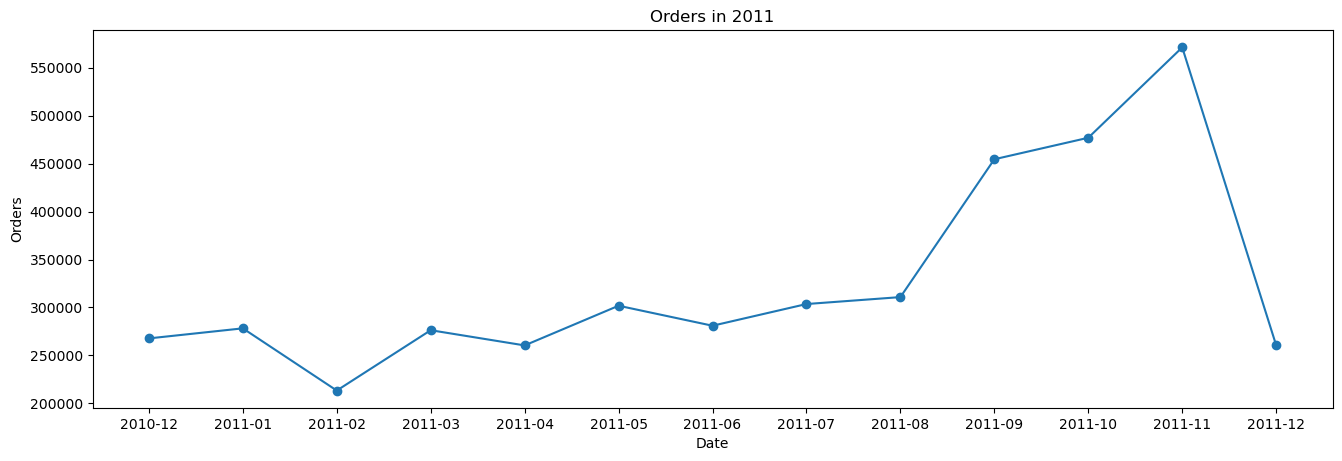

In [125]:
plot_df(df_agg, x=df_agg.Date, y=df_agg.Quantity,title='Orders in 2011')

# Calculating Revenue
Revenue = Order Count * Average Revenue per Order

In [126]:
df['Revenue'] = df['Quantity']*df['UnitPrice']

In [127]:
df_revenue= df.groupby(['InvoiceDate'])['Revenue'].sum().reset_index()
df_revenue.tail()

,InvoiceDate,Revenue
15607,2011-12-09 12:21:00,29.88
15608,2011-12-09 12:23:00,124.60
15609,2011-12-09 12:25:00,140.64
15610,2011-12-09 12:31:00,329.05
15611,2011-12-09 12:49:00,339.20


In [128]:
plot_data = [
    go.Scatter(
        x=df_revenue['InvoiceDate'],
        y=df_revenue['Revenue'],
        mode='lines+markers'
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# RFM ANALYSIS
“RFM” is a method used for analyzing customer value.# 

# 1. Recency
The last invoice date is 2011–12–09, we will use this date to calculate Recency.

In [129]:
NOW = dt.date(2011,12,9) 
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [130]:
df_recency= df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns=['CustomerID','Last_Purchase_Date']
df_recency['Recency']= df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head(10000)


,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3
...,...,...
3915,18280.0,277
3916,18281.0,180
3917,18282.0,7
3918,18283.0,3


<AxesSubplot:xlabel='Recency'>

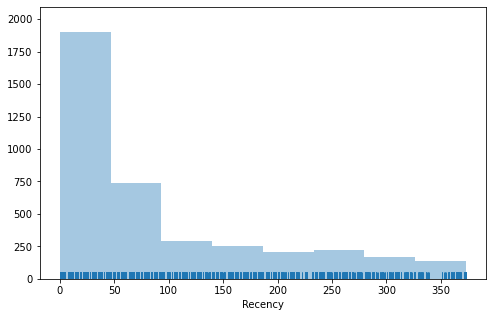

In [131]:
plt.figure(figsize=(8,5))
sns.distplot(df_recency.Recency,bins=8,kde=False,rug=True)

# Frequency — Monetary

In [132]:
FM_Table= df.groupby('CustomerID').agg({'InvoiceNo' : lambda x:len(x),'Revenue' : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo':'Frequency','Revenue':'Monetary'},inplace=True)
FM_Table.head()


,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4595,33719.73
12749.0,199,4090.88
12820.0,59,942.34


<AxesSubplot:xlabel='Monetary'>

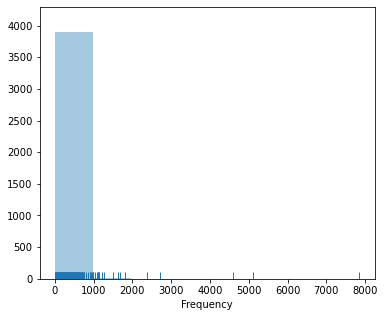

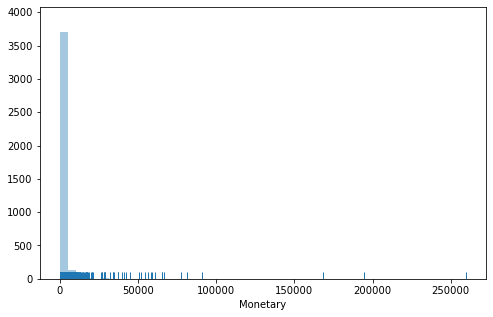

In [133]:
plt.figure(figsize=(6,5))
sns.distplot(FM_Table.Frequency,bins=8,kde=False,rug=True)

plt.figure(figsize=(8,5))
sns.distplot(FM_Table.Monetary,kde=False,rug=True)

In [134]:
RFM_Table =df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head(750)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34
...,...,...,...,...
745,13876.0,63,7,122.70
746,13877.0,86,3,117.24
747,13878.0,54,36,1281.53
748,13880.0,21,165,3219.77


In [135]:
RFM_Table.describe()

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,91.742092,90.388010,1864.385601
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,0.000000,1.000000,3.750000
25%,14208.750000,17.000000,17.000000,300.280000
50%,15569.500000,50.000000,41.000000,652.280000
75%,16913.250000,142.000000,99.250000,1576.585000
max,18287.000000,373.000000,7847.000000,259657.300000


Text(0, 0.5, 'Frequency')

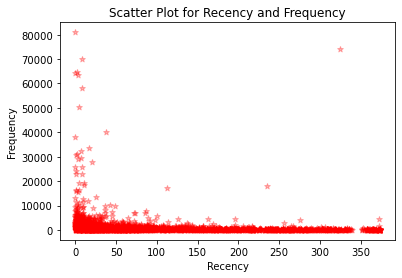

In [136]:
plt.scatter(RFM_Table.groupby('CustomerID')['Recency'].sum(), df.groupby('CustomerID')['Quantity'].sum(),
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Recency')
plt.ylabel('Frequency')

Now we split the metrics into segments using quantiles.We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 4 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [137]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = RFM_Table

In [138]:
def RScore(x,p,d):
    if x<=d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x<= d[p][0.75]:
        return 3
    else :
        return 4
def FMScore(x,p,d) :
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else :
        return 1

In [139]:
segmented_rfm['R_quartile' ] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['F_quartile' ] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
segmented_rfm['M_quartile' ] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
segmented_rfm.head(100)

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,325,1,77183.60,4,4,1
1,12747.0,2,103,4196.01,1,1,1
2,12748.0,0,4595,33719.73,1,1,1
3,12749.0,3,199,4090.88,1,1,1
4,12820.0,3,59,942.34,1,2,2
...,...,...,...,...,...,...,...
95,12949.0,30,215,4167.22,2,1,1
96,12950.0,2,23,1843.00,1,3,1
97,12951.0,8,63,1064.07,1,2,2
98,12952.0,5,79,1387.79,1,2,2


In [140]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head(100)

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12747.0,2,103,4196.01,1,1,1,111,3
2,12748.0,0,4595,33719.73,1,1,1,111,3
3,12749.0,3,199,4090.88,1,1,1,111,3
4,12820.0,3,59,942.34,1,2,2,122,5
...,...,...,...,...,...,...,...,...,...
95,12949.0,30,215,4167.22,2,1,1,211,4
96,12950.0,2,23,1843.00,1,3,1,131,5
97,12951.0,8,63,1064.07,1,2,2,122,5
98,12952.0,5,79,1387.79,1,2,2,122,5


In [141]:
print("Best Customers: ", len(segmented_rfm[segmented_rfm[ 'RFM_Segment'] =='111']))
print('Loyal Customers: ', len(segmented_rfm[segmented_rfm[ 'F_quartile'] == 1]))
print("Big Spenders: ", len(segmented_rfm[segmented_rfm[ 'M_quartile'] == 1]))
print('Lost Customers: ', len(segmented_rfm[segmented_rfm[ 'RFM_Segment'] =='134']))
print('Best Customers: ', len(segmented_rfm[segmented_rfm[ 'RFM_Segment'] =='344']))
print('Lost Cheap Customers: ', len(segmented_rfm[segmented_rfm[ 'RFM_Segment'] =='444']))

Best Customers:  409
Loyal Customers:  980
Big Spenders:  980
Lost Customers:  21
Best Customers:  168
Lost Cheap Customers:  343


In [142]:
segmented_rfm['RFM_Score'].unique()

array([ 9,  3,  5, 12,  7,  8,  6, 10, 11,  4], dtype=int64)

In [143]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3             6.6     363.7   8218.2   409
4            20.3     187.0   3492.1   345
5            32.0     113.3   1909.4   386
6            47.0      78.9   1806.6   380
7            60.5      55.4    917.1   408
8            78.1      38.5    733.0   393
9            96.7      28.4    829.5   424
10          153.0      21.0    357.0   470
11          174.0      13.7    234.2   362
12          257.9       8.1    152.3   343

# Now Clustering the data !!!! Using Repetitive Median K-Means(RM K-Means)

In [144]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    


Recency's: Skew: 1.244516494686479, : SkewtestResult(statistic=25.283720058978158, pvalue=4.8246481722257944e-141)
Frequency's: Skew: 18.66163311873067, : SkewtestResult(statistic=80.10349526126947, pvalue=0.0)
Monetary's: Skew: 20.190728787200957, : SkewtestResult(statistic=81.75346911703686, pvalue=0.0)


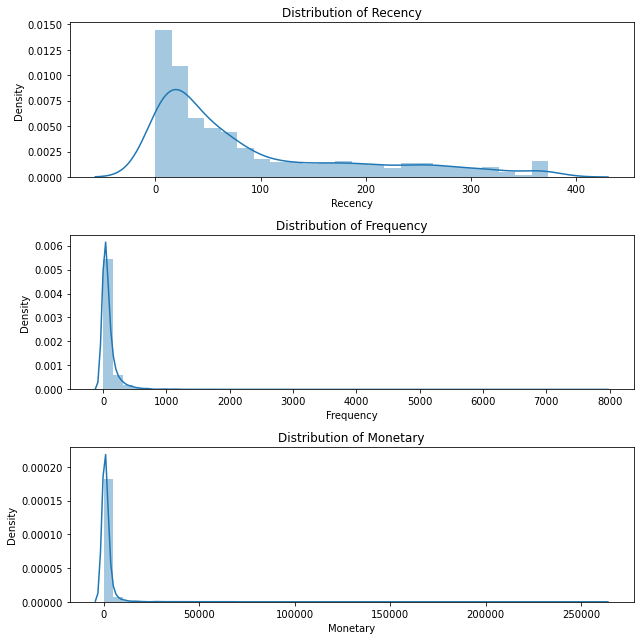

In [145]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

In [146]:
df_rfm_log = RFM_Table[['CustomerID', 'Recency', 'Frequency', 'Monetary']] 
rfm_or = RFM_Table[['CustomerID', 'Recency', 'Frequency', 'Monetary']] 
df_rfm_log['CustomerID'] = df_rfm_log['CustomerID'].astype(int)
df_rfm_log['Monetary'] = df_rfm_log['Monetary'].astype(int)
df_rfm_log['Recency'] = df_rfm_log['Recency'].astype(int)
df_rfm_log['Frequency'] = df_rfm_log['Frequency'].astype(int)
rfm_or['CustomerID'] = rfm_or['CustomerID'].astype(int)
df_rfm_log.head(100)


,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183
1,12747,2,103,4196
2,12748,0,4595,33719
3,12749,3,199,4090
4,12820,3,59,942
...,...,...,...,...
95,12949,30,215,4167
96,12950,2,23,1843
97,12951,8,63,1064
98,12952,5,79,1387


In [147]:
rfm_or.head(100)

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,2,103,4196.01
2,12748,0,4595,33719.73
3,12749,3,199,4090.88
4,12820,3,59,942.34
...,...,...,...,...
95,12949,30,215,4167.22
96,12950,2,23,1843.00
97,12951,8,63,1064.07
98,12952,5,79,1387.79


Recency's: Skew: -0.4635591539552193, : SkewtestResult(statistic=-11.314301280234206, pvalue=1.114869536941138e-29)
Frequency's: Skew: -0.02600696239989871, : SkewtestResult(statistic=-0.6659021000684195, pvalue=0.5054736781086501)
Monetary's: Skew: 0.36293182262156487, : SkewtestResult(statistic=9.014155659399604, pvalue=1.983927854641744e-19)


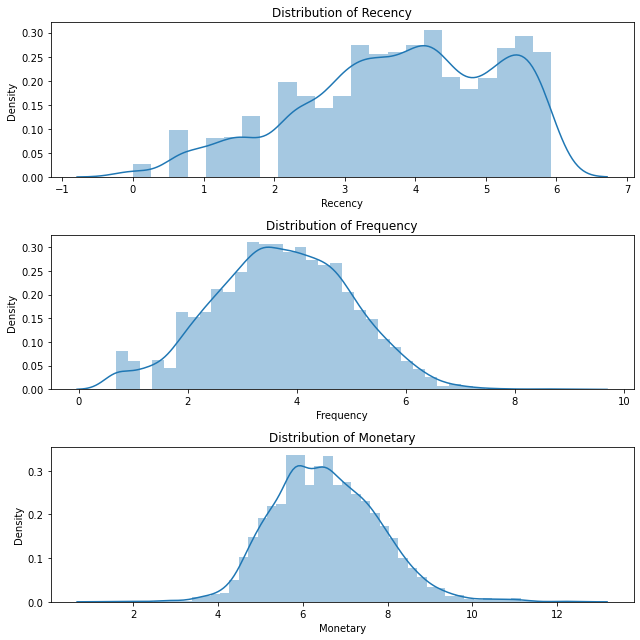

In [148]:
#Removing the skewness of the data
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [149]:
df_rfm_log.describe()

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,9.647473,3.798750,3.721360,6.544758
std,0.102110,1.382343,1.260138,1.245297
min,9.421168,0.000000,0.693147,1.386294
25%,9.561684,2.890372,2.890372,5.707110
50%,9.653133,3.931826,3.737670,6.480811
75%,9.735912,4.962845,4.607658,7.363121
max,9.814000,5.924256,8.968014,12.467121


In [150]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [151]:
df_rfm_log = windsoriser.transform(df_rfm_log)

In [152]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [179]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head(100)

,CustomerID,Recency,Frequency,Monetary
0,-2.216570,1.465297,-2.075758,2.144730
1,-1.903521,-2.017919,0.758484,1.551182
2,-1.902753,-2.065875,2.073202,2.144730
3,-1.901985,-1.804182,1.296742,1.529279
4,-1.847594,-1.804182,0.305732,0.272810
...,...,...,...,...
95,-1.749536,-0.282825,1.360090,1.545245
96,-1.748780,-2.017919,-0.448482,0.847007
97,-1.748024,-1.201692,0.358855,0.376980
98,-1.747267,-1.502937,0.542528,0.603780


In [154]:
range_n_clusters = range(5,6)
eval_scores = {'model':[],'n_clusters':[], 's_score':[], 'c_score':[], 'db_score':[]}

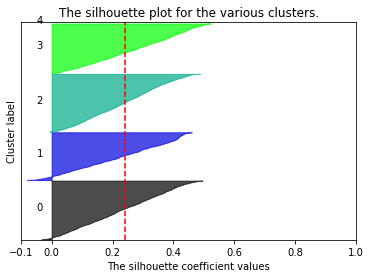

In [155]:
for n_clusters in range_n_clusters:
    fig=plt.figure()
    ax=plt.axes()
    
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(RFM_Table_scaled) + (n_clusters + 1) * 10])
    clusterer = rmkm(n_clusters=4, random_state=77, init='k-means++')
    eval_scores['model'].append('rmkm')
    
    cluster_labels = clusterer.fit_predict(RFM_Table_scaled)
    silhouette_avg = silhouette_score(RFM_Table_scaled, cluster_labels, random_state = 77)
   
    eval_scores['n_clusters'].append(n_clusters)
    eval_scores['s_score'].append(silhouette_avg)
    eval_scores['c_score'].append(metrics.calinski_harabasz_score(RFM_Table_scaled, cluster_labels))
    eval_scores['db_score'].append(metrics.davies_bouldin_score(RFM_Table_scaled, cluster_labels))
    
    sample_silhouette_values = silhouette_samples(RFM_Table_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [156]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    rmkmeanModel = rmkm(n_clusters=k).fit(RFM_Table_scaled) 
    rmkmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, rmkmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(rmkmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, rmkmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = rmkmeanModel.inertia_ 

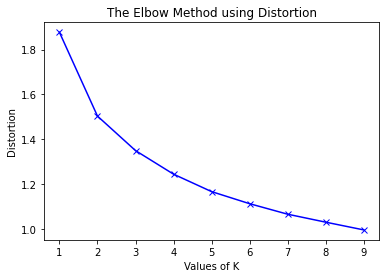

In [157]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

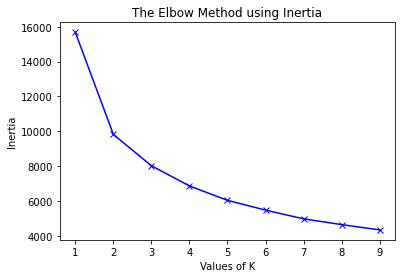

In [158]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [159]:
def rkmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    rkmeans = rmkm(n_clusters = clusters_number, random_state = 1)
    rkmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = rkmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

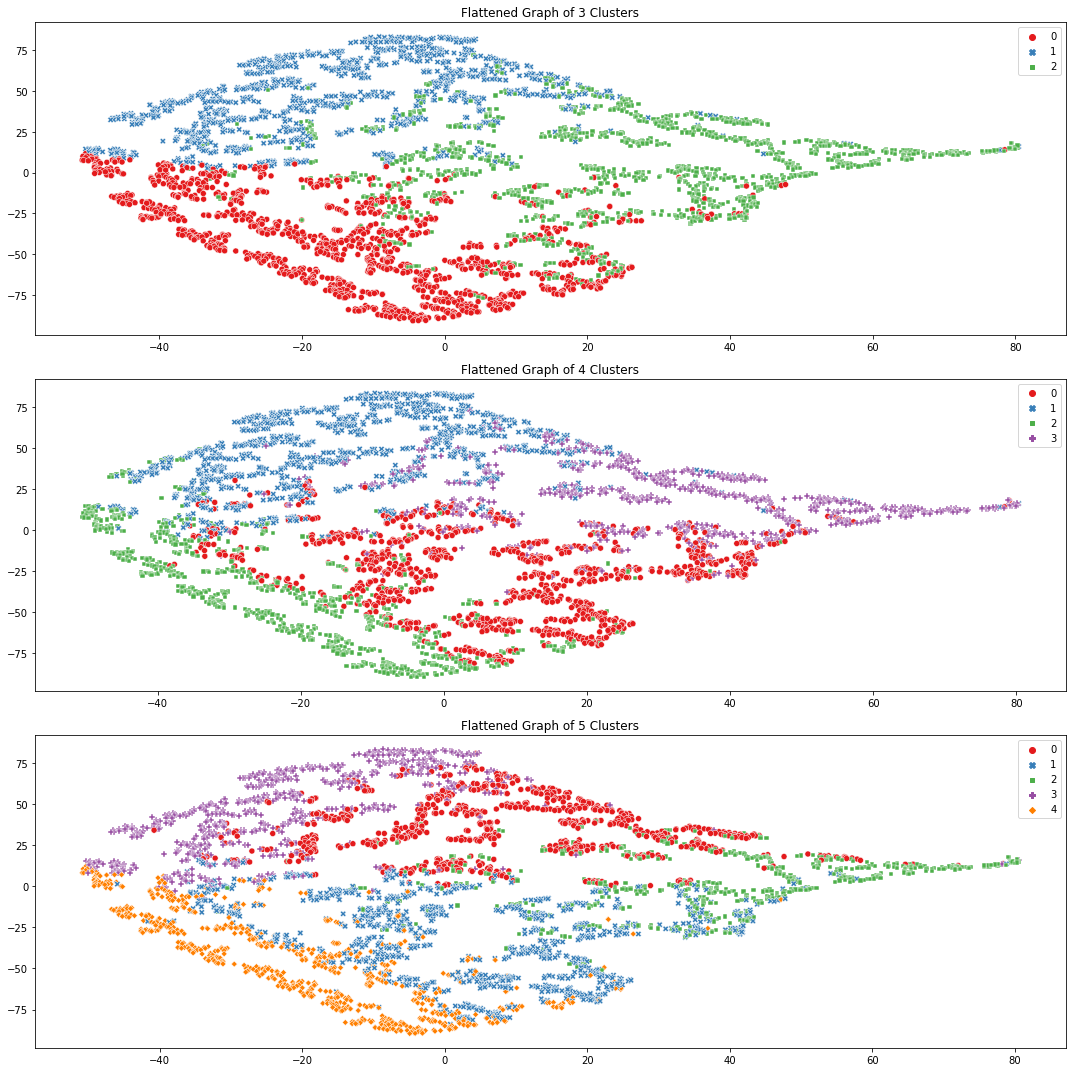

In [160]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
df_rfm_k3 = rkmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = rkmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = rkmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()

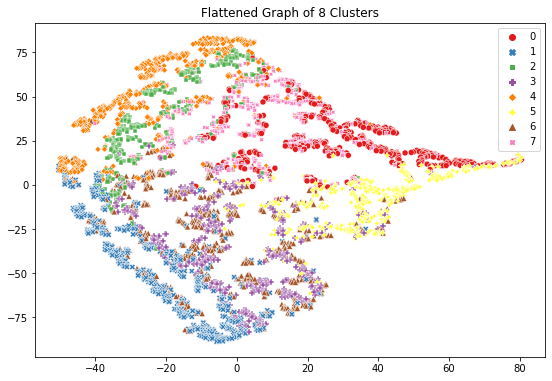

In [161]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 2)
df_rfm_k6 = rkmeans(RFM_Table_scaled, 6, RFM_Table)

plt.subplot(1, 3, 2)
df_rfm_k7 = rkmeans(RFM_Table_scaled, 7, RFM_Table)

plt.subplot(3, 2, 4)
df_rfm_k8 = rkmeans(RFM_Table_scaled, 8, RFM_Table)

plt.tight_layout()

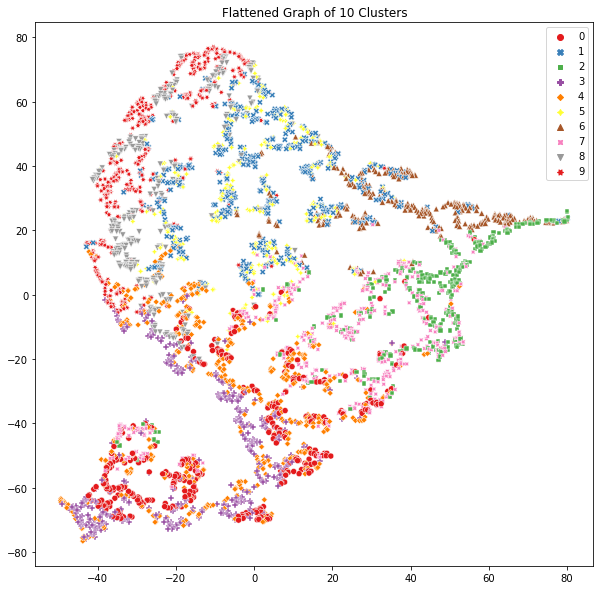

In [162]:
plt.figure(figsize=(10,10))
df_rfm_k10 = rkmeans(RFM_Table_scaled, 10, rfm_or)

In [163]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

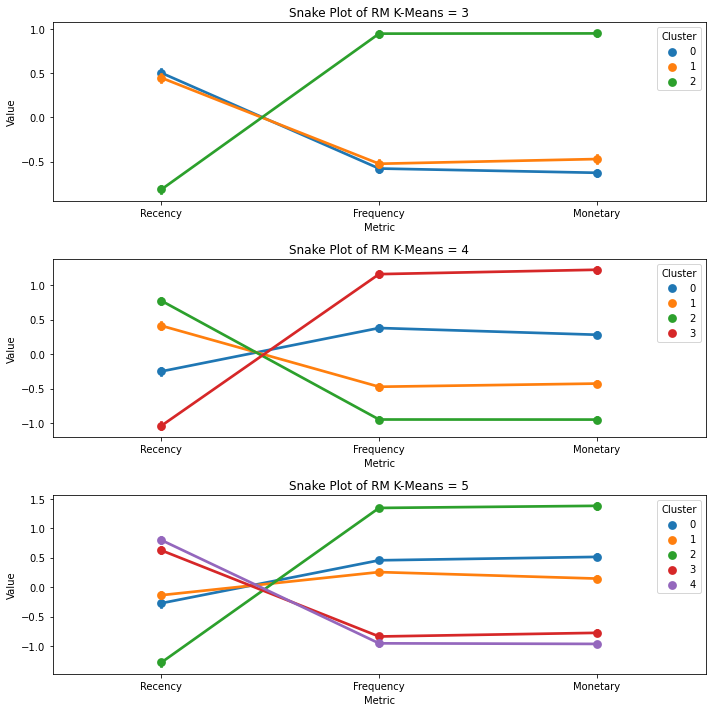

In [164]:
plt.figure(figsize=(10,10 ))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of RM K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of RM K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of RM K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

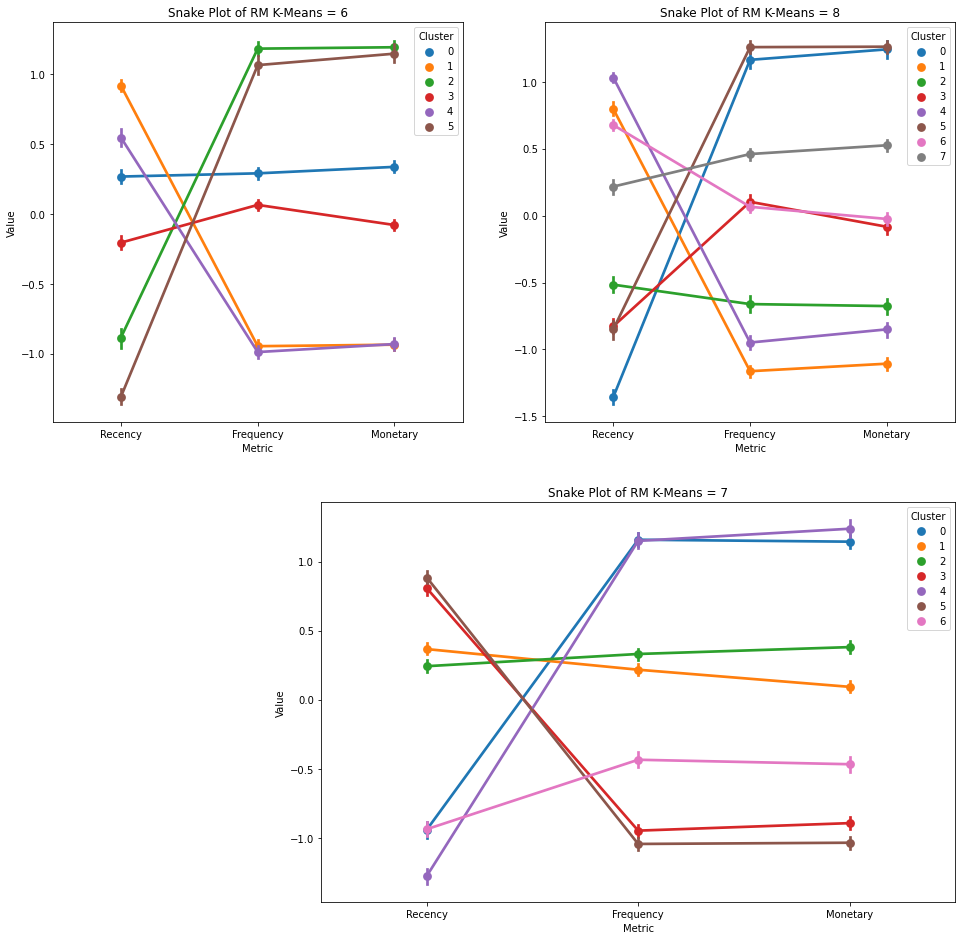

In [165]:
plt.figure(figsize=(25,25))

plt.subplot(3, 3, 2)
plt.title('Snake Plot of RM K-Means = 6')
snake_plot(RFM_Table_scaled, df_rfm_k6, RFM_Table)


plt.subplot(3, 2, 4)
plt.title('Snake Plot of RM K-Means = 7')
snake_plot(RFM_Table_scaled, df_rfm_k7, RFM_Table)

plt.subplot(3, 3, 3)
plt.title('Snake Plot of RM K-Means = 8')
snake_plot(RFM_Table_scaled, df_rfm_k8, RFM_Table)

plt.tight_layout()

# Visualisation of Exploratory Data Analysis (EDA)

In [190]:
df_cleaned = df[['Country','Revenue','CustomerID','Quantity','UnitPrice','InvoiceNo','InvoiceDate']].copy(deep = True)

In [167]:
revenue_per_countries = df_cleaned.groupby(["Country"])["Revenue"].sum().sort_values()
revenue_per_countries = pd.DataFrame(revenue_per_countries)
revenue_per_countries['percent'] = revenue_per_countries['Revenue']/revenue_per_countries['Revenue'].sum()
revenue_per_countries['percent'] = revenue_per_countries['percent']*100
revenue_per_countries = revenue_per_countries.sort_values(by=['percent'], ascending=True)
revenue_per_countries = revenue_per_countries.head(15)

In [168]:
print(revenue_per_countries)

                    Revenue  percent
Country                             
United Kingdom  7308391.554    100.0


([0], [Text(0, 0, '')])

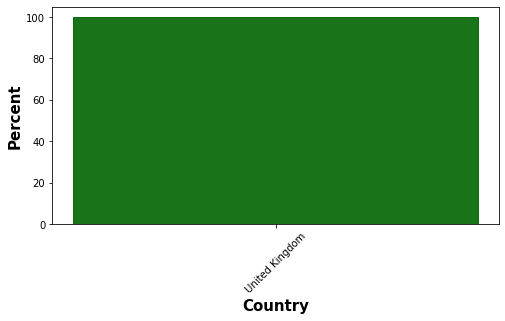

In [170]:
plt.figure(figsize=(8,4))
revenue_per_countries = revenue_per_countries.reset_index(drop=True)
barplot = plt.bar(revenue_per_countries['Country'], revenue_per_countries['percent'], color = 'lightgreen', alpha = 0.90)
barplot[0].set_color('darkgreen')
barplot[0].set_color('darkgreen')
barplot[0].set_color('darkgreen')
plt.xlabel('Country', fontsize = 15, weight = 'bold')
plt.ylabel('Percent', fontsize = 15, weight = 'bold')
plt.xticks(rotation=45)


In [172]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [174]:
rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          51.0      83.0   1405.0  1058
1         120.0      31.0    672.0  1079
2         174.0      16.0    288.0   926
3          18.0     255.0   5635.0   857

In [175]:
rfm_values(df_rfm_k5)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          51.0      88.0   1648.0   753
1          58.0      70.0   1074.0   979
2          11.0     315.0   7222.0   610
3         151.0      18.0    490.0   805
4         177.0      16.0    280.0   773

In [176]:
rfm_values(df_rfm_k6)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          89.0      70.0   1468.0   699
1         193.0      16.0    292.0   733
2          22.0     237.0   5678.0   534
3          52.0      54.0    767.0   837
4         143.0      15.0    282.0   673
5          10.0     252.0   4963.0   444

In [177]:
rfm_values(df_rfm_k7)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          18.0     233.0   5236.0   536
1          97.0      64.0    989.0   676
2          83.0      73.0   1500.0   599
3         173.0      15.0    299.0   631
4          10.0     268.0   5326.0   412
5         185.0      14.0    253.0   619
6          16.0      31.0    884.0   447

In [178]:
rfm_values(df_rfm_k8)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           9.0     276.0   5458.0   386
1         173.0      11.0    232.0   554
2          28.0      22.0    383.0   368
3          18.0      57.0   1124.0   475
4         205.0      15.0    469.0   519
5          22.0     256.0   5827.0   471
6         136.0      53.0    897.0   608
7          79.0      84.0   1604.0   539

In [192]:
df_cleaned['AmountSpent']=df_cleaned['Quantity']*df_cleaned['UnitPrice']
invoice_customer_df=df_cleaned.groupby(by=['InvoiceNo','InvoiceDate']).agg({'AmountSpent':sum,'CustomerID':max,'Country':max,}).reset_index()
invoice_customer_df.head(100)

,InvoiceNo,InvoiceDate,AmountSpent,CustomerID,Country
0,536365,2010-12-01 08:26:00,139.12,17850.0,United Kingdom
1,536366,2010-12-01 08:28:00,22.20,17850.0,United Kingdom
2,536367,2010-12-01 08:34:00,278.73,13047.0,United Kingdom
3,536368,2010-12-01 08:34:00,70.05,13047.0,United Kingdom
4,536369,2010-12-01 08:35:00,17.85,13047.0,United Kingdom
...,...,...,...,...,...
95,536576,2010-12-01 16:11:00,2558.42,13777.0,United Kingdom
96,536577,2010-12-01 16:13:00,497.00,13777.0,United Kingdom
97,536578,2010-12-01 16:15:00,279.60,17690.0,United Kingdom
98,536579,2010-12-01 16:16:00,315.96,13777.0,United Kingdom


In [193]:
monthly_unique_customer_df=df_cleaned.set_index('InvoiceDate')['CustomerID'].resample('M').nunique()
monthly_unique_customer_df
monthly_revenue_df=df_cleaned.set_index('InvoiceDate')['AmountSpent'].resample('M').sum()
monthly_rev_repeat_customer_df=invoice_customer_df.set_index('InvoiceDate').groupby([pd.Grouper(freq='M'),'CustomerID']).filter(lambda x:len(x) > 1).resample('M').sum()['AmountSpent']
monthly_rev_per_repeat_customers_df=monthly_rev_repeat_customer_df/monthly_revenue_df*100
monthly_rev_per_repeat_customers_df
monthly_repeat_customers_df=invoice_customer_df.set_index('InvoiceDate').groupby([pd.Grouper(freq='M'),'CustomerID']).filter(lambda x:len(x)>1).resample('M').nunique()['CustomerID']
monthly_repeat_customers_df

InvoiceDate
2010-12-31    241
2011-01-31    142
2011-02-28    137
2011-03-31    179
2011-04-30    162
2011-05-31    253
2011-06-30    205
2011-07-31    208
2011-08-31    176
2011-09-30    247
2011-10-31    285
2011-11-30    498
2011-12-31    101
Freq: M, Name: CustomerID, dtype: int64

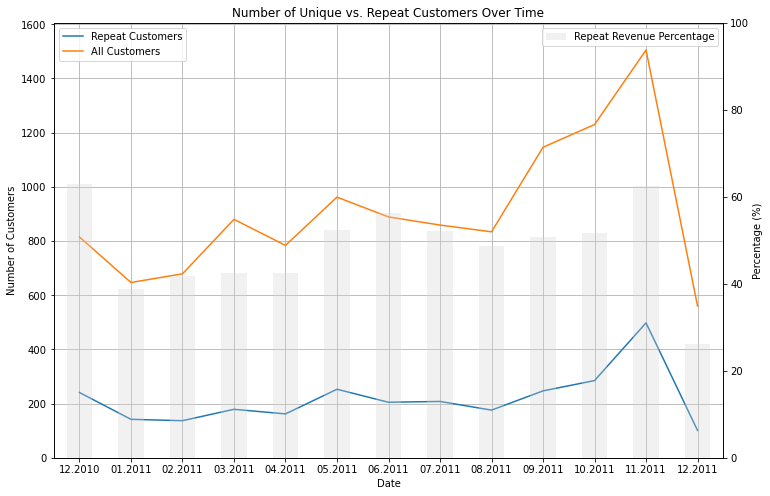

In [194]:
ax=pd.DataFrame(monthly_repeat_customers_df.values).plot(figsize=(12,8))
pd.DataFrame(monthly_unique_customer_df.values).plot(ax=ax,grid=True)
ax2=ax.twinx()
pd.DataFrame(monthly_rev_per_repeat_customers_df.values).plot(ax=ax2,kind='bar',color='lightgrey',alpha=0.3)
ax2.set_ylim([0,max(monthly_rev_per_repeat_customers_df.values)+30])
ax2.set_ylabel('Percentage (%)')
ax2.set_xticklabels([x.strftime('%m.%Y') for x in monthly_rev_per_repeat_customers_df.index])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Unique vs. Repeat Customers Over Time')
ax.legend(['Repeat Customers','All Customers'])
ax2.legend(['Repeat Revenue Percentage'],loc='upper right')
ax.set_ylim([0,monthly_unique_customer_df.values.max()+100])
ax2.set_ylim([0,100])
plt.xticks(range(len(monthly_repeat_customers_df.index)),[x.strftime('%m.%Y') for x in monthly_repeat_customers_df.index],rotation=45)
plt.show()

# Confusion Matrix Of the data

In [208]:
df_RFM_M = RFM_Table.pivot(index='Monetary', columns='Recency', values='Monetary')
df_RFM_M= RFM_Table.reset_index().sort_values(['Monetary'], ascending = True).set_index(['Monetary'])
df_RFM_M.head(10)

,index,CustomerID,Recency,Frequency,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
Monetary,,,,,,,,,
3.75,2807,16738.0,297,1,4,4,4,444,12
6.20,1398,14792.0,63,2,3,4,4,344,11
6.90,2604,16454.0,44,2,2,4,4,244,10
12.75,3680,17956.0,249,1,4,4,4,444,12
13.30,2913,16878.0,84,3,3,4,4,344,11
15.00,351,13307.0,120,1,3,4,4,344,11
15.00,3545,17763.0,263,1,4,4,4,444,12
15.00,2150,15823.0,372,1,4,4,4,444,12
17.00,2336,16093.0,106,1,3,4,4,344,11


In [206]:
df_RFM_C = RFM_Table.pivot(index='Monetary', columns='Recency', values='CustomerID')
df_RFM_C= RFM_Table.reset_index().sort_values(['Monetary'], ascending = True).set_index(['Monetary'])
df_RFM_C.head(10)

,index,CustomerID,Recency,Frequency,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
Monetary,,,,,,,,,
3.75,2807,16738.0,297,1,4,4,4,444,12
6.20,1398,14792.0,63,2,3,4,4,344,11
6.90,2604,16454.0,44,2,2,4,4,244,10
12.75,3680,17956.0,249,1,4,4,4,444,12
13.30,2913,16878.0,84,3,3,4,4,344,11
15.00,351,13307.0,120,1,3,4,4,344,11
15.00,3545,17763.0,263,1,4,4,4,444,12
15.00,2150,15823.0,372,1,4,4,4,444,12
17.00,2336,16093.0,106,1,3,4,4,344,11


In [209]:
df_RFM_R = RFM_Table.pivot(index='Monetary', columns='Recency', values='Recency')
df_RFM_R= RFM_Table.reset_index().sort_values(['Monetary'], ascending = False).set_index(['Monetary'])
df_RFM_R.head(10)

,index,CustomerID,Recency,Frequency,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
Monetary,,,,,,,,,
259657.30,3783,18102.0,0,431,1,1,1,111,3
194550.79,3314,17450.0,8,337,1,1,1,111,3
168472.50,2598,16446.0,0,3,1,4,1,141,6
91062.38,3356,17511.0,2,963,1,1,1,111,3
81024.84,2294,16029.0,38,242,2,1,1,211,4
77183.60,0,12346.0,325,1,4,4,1,441,9
66653.56,2766,16684.0,4,277,1,1,1,111,3
65164.79,902,14096.0,4,5111,1,1,1,111,3
65039.62,620,13694.0,3,568,1,1,1,111,3


              precision    recall  f1-score   support

           3       0.99      0.99      0.99       125
           4       0.98      1.00      0.99       106
           5       1.00      0.99      1.00       126
           6       0.99      0.99      0.99       120
           7       1.00      0.98      0.99       119
           8       0.99      0.99      0.99       115
           9       0.99      0.98      0.99       108
          10       0.99      1.00      0.99       147
          11       1.00      1.00      1.00       109
          12       1.00      1.00      1.00       101

    accuracy                           0.99      1176
   macro avg       0.99      0.99      0.99      1176
weighted avg       0.99      0.99      0.99      1176

[[124   1   0   0   0   0   0   0   0   0]
 [  0 106   0   0   0   0   0   0   0   0]
 [  0   1 125   0   0   0   0   0   0   0]
 [  1   0   0 119   0   0   0   0   0   0]
 [  0   0   0   1 117   1   0   0   0   0]
 [  0   0   0   0   0 114 

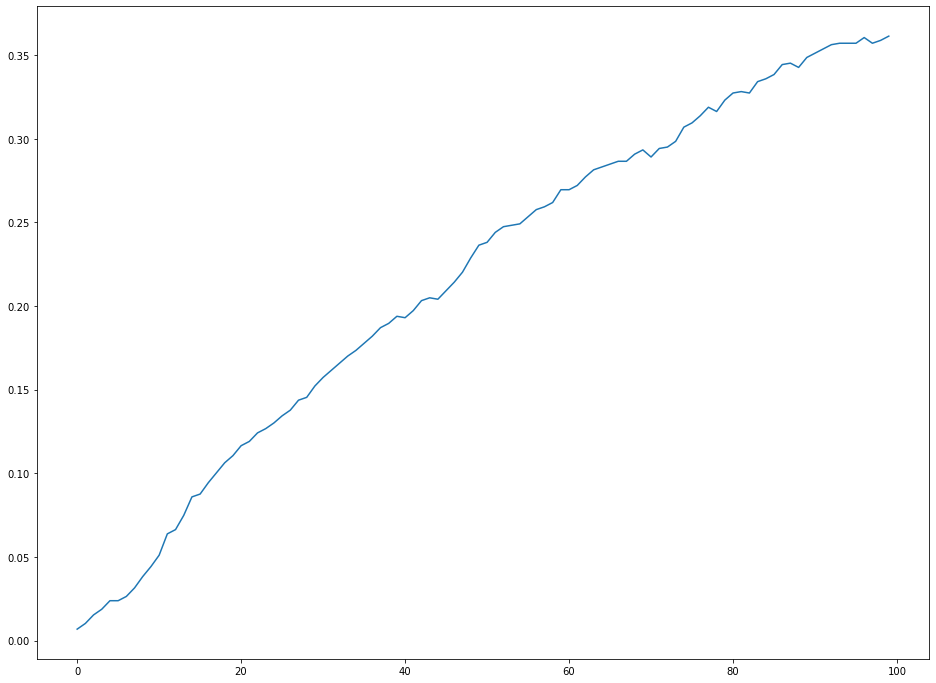

In [214]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler

#Standardize the data set

scaler = StandardScaler()

scaler.fit(segmented_rfm.drop('RFM_Score', axis=1))

scaled_features = scaler.transform(segmented_rfm.drop('RFM_Score', axis=1))

scaled_data = pd.DataFrame(scaled_features, columns = segmented_rfm.drop('RFM_Score', axis=1).columns)

#Split the data set into training data and test data

from sklearn.model_selection import train_test_split

x = scaled_data

y = segmented_rfm['RFM_Score']

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3)

#Train the model and make predictions

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 1)

model.fit(x_training_data, y_training_data)

predictions = model.predict(x_test_data)

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

print(classification_report(y_test_data, predictions))

print(confusion_matrix(y_test_data, predictions))

error_rates = []

for i in np.arange(1, 101):

    new_model = KNeighborsClassifier(n_neighbors = i)

    new_model.fit(x_training_data, y_training_data)

    new_predictions = new_model.predict(x_test_data)

    error_rates.append(np.mean(new_predictions != y_test_data))

plt.figure(figsize=(16,12))

plt.plot(error_rates)